In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [2]:
opp_df = pd.read_parquet('../../data/cleaned/opportunity/opportunity.parquet')

In [3]:
alpha = 0.05

### Q1. Is time taken between stage transitions significantly different across geographies?

- Here, the null hypothesis **h0**, is that 2 geographies have same mean time taken.
- **h1** is that they have different mean.

In [4]:
time_diff_data = opp_df.groupby(['opportunity_id',
                                 'transition_to_stage','transition_from_stage_name','geography'],
                                as_index=False).agg({'transition_to_timestamp':'max',
                                                     'transition_from_timestamp':'min'})

In [5]:
time_diff_data['transition_time'] = (time_diff_data['transition_to_timestamp'] - time_diff_data['transition_from_timestamp']).dt.total_seconds()/(3600*24)

In [6]:
geo_time_data = time_diff_data.groupby(['geography', 'transition_from_stage_name', 'transition_to_stage'], 
                                       as_index = False)['transition_time'].mean()

In [7]:
geo = dict()
for i in geo_time_data['geography'].unique():
    key_ = i
    geo[i]= geo_time_data[geo_time_data['geography'] == i]

In [8]:
print("\nCase_1\nh0 for Geo 1 and Geo 2\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 2']['transition_time'])[1].round(3)>alpha)
print("\nCase_2\nh0 for Geo 1 and Geo 3\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 3']['transition_time'])[1].round(3)>alpha)
print("\nCase_3\nh0 for Geo 1 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_4\nh0 for Geo 1 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_5\nh0 for Geo 2 and Geo 3\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 3']['transition_time'])[1].round(3)>alpha)
print("\nCase_6\nh0 for Geo 2 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_7\nh0 for Geo 2 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_8\nh0 for Geo 3 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 3']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_9\nh0 for Geo 3 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 3']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_10\nh0 for Geo 4 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 4']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)


Case_1
h0 for Geo 1 and Geo 2
Reject Null Hypothesis? : False

Case_2
h0 for Geo 1 and Geo 3
Reject Null Hypothesis? : True

Case_3
h0 for Geo 1 and Geo 4
Reject Null Hypothesis? : False

Case_4
h0 for Geo 1 and Geo 5
Reject Null Hypothesis? : True

Case_5
h0 for Geo 2 and Geo 3
Reject Null Hypothesis? : True

Case_6
h0 for Geo 2 and Geo 4
Reject Null Hypothesis? : True

Case_7
h0 for Geo 2 and Geo 5
Reject Null Hypothesis? : True

Case_8
h0 for Geo 3 and Geo 4
Reject Null Hypothesis? : True

Case_9
h0 for Geo 3 and Geo 5
Reject Null Hypothesis? : True

Case_10
h0 for Geo 4 and Geo 5
Reject Null Hypothesis? : True


In [9]:
mean_geo_time = [geo[i]['transition_time'].mean() for i in geo_time_data['geography'].unique()]

<AxesSubplot:>

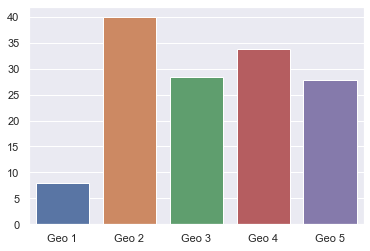

In [10]:
sns.set()
sns.barplot(x = ['Geo 1', 'Geo 2', 'Geo 3', 'Geo 4', 'Geo 5'], y = mean_geo_time)

### Q2. Are Losses (Opportunity lines in Lost stage) more likely to happen in early stages (Qualify and define)

- Here, the null hypothesis **h0**, is that losses happen more in early stages.
- **h1** is that losses happen less in early stages.

In [11]:
stage_df = opp_df[opp_df['transition_to_stage'] != opp_df['transition_from_stage_name']][['opportunity_id',
                                                                                         'transition_from_stage_name',
                                                                                         'transition_to_stage']]

In [12]:
stage_df['early_stages'] = stage_df['transition_from_stage_name'].apply(lambda x: x in ['Stage 0', 'Stage 5', 'Stage 6'])
stage_df['lost'] = stage_df['transition_to_stage'].apply(lambda x: x in ['Stage 1', 'Stage 8'])

In [23]:
early_df = stage_df[stage_df['early_stages'] == True]
non_early_df = stage_df[stage_df['early_stages'] == False]
non_early_df = non_early_df[(non_early_df['transition_from_stage_name'] == 'Stage 2') | 
                            (non_early_df['transition_from_stage_name'] == 'Stage 3') |
                            (non_early_df['transition_from_stage_name'] == 'Stage 7')].copy()

In [51]:
X1 = early_df['lost'].sum()
X2 = non_early_df['lost'].sum()
n1 = early_df['lost'].count()
n2 = non_early_df['lost'].count()
p1 = X1/n1
p2 = X2/n2
p0 = (X1+X2)/(n1+n2)

z_score = p1 - p2 / np.sqrt(p0 * (1 - p0) * (1/n1 + 1/n2))

In [52]:
z_crit = stats.norm.ppf(alpha)

In [53]:
print('The z-score is : ', z_score, ' and the critical z-score for 5% significance is ', z_crit)
print('So null hypothesis is rejected')

The z-score is :  -17.020246839523903  and the critical z-score for 5% significance is  -1.6448536269514729
So null hypothesis is rejected


lost          False  True 
early_stages              
False          3883    276
True           8407    283


<AxesSubplot:xlabel='True', ylabel='count'>

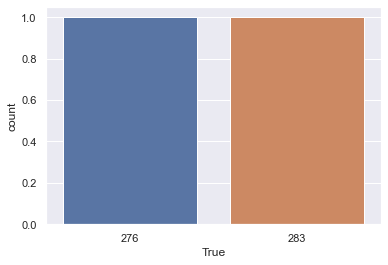

In [62]:
cross_tab = pd.crosstab(stage_df['early_stages'], stage_df['lost'])
print(cross_tab)
sns.countplot(cross_tab[True])

### Q3. Does the proportion of Won lines in an Opportunity significantly different across Product Categories?

- Here, the null hypothesis **h0**, is that the proportion of Won lines in an Opportunity significantly similar across Product Categories.
- **h1** is that the proportion of Won lines in an Opportunity significantly different across Product Categories.

In [19]:
pro_seg_df = opp_df[['core_product_segment', 'opportunity_status']].copy()

In [21]:
pro_seg_df['target'] = np.where(pro_seg_df['opportunity_status'] == 'Closed/Won', True, False)

In [22]:
ct = pd.crosstab(pro_seg_df['core_product_segment'], pro_seg_df['target'])
stat, p, dof, expected = stats.chi2_contingency(ct)

if p < alpha:
    print('Reject Null Hypothesis')
else:
    print('Failed to Reject Null Hypothesis')

print('p-value:', round(p, 3))


Reject Null Hypothesis
p-value: 0.0


Null Hypothesis is reject i.e, proportion of won is different for different product categories.